In [1]:
import os
import re

import pandas as pd
import skimage as ski
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
def path(text):
    return os.path.join(*text.split("/"))

# Parameters

In [3]:
DATASET_PATH = path("../dataset.csv")
KS_IMAGES_PATH = path("../../../ksc-data/images")
FEATURES_PATH = path("../features/old.vgg19.npy")

SEED = 42
TRAIN_TEST_SPLIT_SIZE = 0.7
CLASSES = ['Ia', 'IIb', 'IIIb']
# CLASSES = None
WITH_OTHER = True  # If True, kidney stones which don't fall into preceding 'CLASSES' will be put in an 'Other' class

BATCH_SIZE = 64

# Dataset loading

In [4]:
df = pd.read_csv(DATASET_PATH)

In [5]:
POTENTIAL_CLASSES = df.stone_class.unique().tolist()
if CLASSES is None:
    CLASSES = POTENTIAL_CLASSES
    WITH_OTHER = False

In [6]:
df['type_image'] = df.SEC.map(lambda x: 'SEC' if x else 'SUR')

In [7]:
df.head()

,filename,stone_class,class_level_1,class_level_2,filetype,SUR,SEC,type_image
0,Ia_SEC_1.jpg,Ia,I,a,jpg,False,True,SEC
1,Ia_SEC_10.jpg,Ia,I,a,jpg,False,True,SEC
2,Ia_SEC_11.jpg,Ia,I,a,jpg,False,True,SEC
3,Ia_SEC_12.jpg,Ia,I,a,jpg,False,True,SEC
4,Ia_SEC_13.jpg,Ia,I,a,jpg,False,True,SEC


In [8]:
filtered_df = df

In [9]:
rng = np.random.default_rng(SEED)
indices = filtered_df.index.values
rng.shuffle(indices)

In [10]:
features = np.load(FEATURES_PATH)
features.shape

(203, 4, 7, 7, 512)

In [11]:
X = features[indices]

In [12]:
def classes_mapper(y):
    try:
        return CLASSES.index(y)
    except Exception as e:
        if WITH_OTHER:
            return len(CLASSES)
        raise e

In [13]:
def inverse_class_mapper(pred):
    return (CLASSES + ['Other'] if WITH_OTHER else CLASSES)[pred]

In [14]:
shuffled_df = pd.DataFrame(filtered_df.iloc[indices])

In [15]:
shuffled_df['class_number'] = shuffled_df.stone_class.map(classes_mapper)

In [16]:
Y = shuffled_df.class_number.values

In [17]:
print(Y)

[3 0 3 0 0 0 3 3 3 3 0 3 1 0 2 3 3 0 3 0 2 3 3 2 3 1 0 3 3 3 3 3 3 0 0 1 3
 2 3 1 3 0 0 0 3 3 1 0 3 1 1 1 1 0 2 2 3 1 0 1 0 0 2 3 3 1 3 3 0 0 3 0 3 2
 0 3 1 3 3 3 0 2 3 3 0 3 2 0 1 2 0 3 2 3 2 3 2 2 1 3 3 1 0 1 1 3 0 3 3 2 2
 3 3 3 3 1 1 3 2 0 2 1 1 1 3 3 3 3 1 3 3 3 2 3 2 3 2 0 2 2 3 0 0 2 0 3 0 3
 3 0 3 3 2 3 1 3 0 2 0 3 3 3 3 3 0 3 3 0 3 1 2 0 0 0 3 0 0 3 0 3 0 0 1 3 2
 3 0 3 0 0 3 3 0 3 2 3 0 2 3 0 1 3 2]


In [18]:
train_size = int(TRAIN_TEST_SPLIT_SIZE * shuffled_df.shape[0])

In [19]:
X_train = X[:train_size]
Y_train = Y[:train_size]

Y_train = np.reshape(Y_train, (Y_train.shape[0], -1))
Y_train = np.repeat(Y_train, X_train.shape[1], axis=-1)
Y_train = np.reshape(Y_train, (-1,))
print(f"Y_train.shape = {Y_train.shape}")

X_train = np.reshape(X_train, (-1,) + X_train.shape[2:])
X_train = np.reshape(X_train, (X_train.shape[0], -1))
print(f"X_train.shape = {X_train.shape}")

Y_train.shape = (568,)
X_train.shape = (568, 25088)


In [20]:
X_test = X[train_size:]
Y_test = Y[train_size:]

X_test = X_test[:, 0, ...]
X_test = np.reshape(X_test, (-1,) + X_test.shape[1:])
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(f"X_test.shape = {X_test.shape}")

print(f"Y_test.shape = {Y_test.shape}")

X_test.shape = (61, 25088)
Y_test.shape = (61,)


# Model creation

In [21]:
hidden_layers = (500,)
nb_classes = len(CLASSES) + int(WITH_OTHER)

In [22]:
classifier = MLPClassifier(hidden_layers, batch_size=BATCH_SIZE, verbose=True, random_state=SEED, early_stopping=True)

In [23]:
classifier.fit(X_train, Y_train)

Iteration 1, loss = 7.14913862
Validation score: 0.649123
Iteration 2, loss = 1.83709592
Validation score: 0.894737
Iteration 3, loss = 0.78434202
Validation score: 0.877193
Iteration 4, loss = 0.11554033
Validation score: 0.877193
Iteration 5, loss = 0.03284237
Validation score: 0.894737
Iteration 6, loss = 0.00107680
Validation score: 0.912281
Iteration 7, loss = 0.00575505
Validation score: 0.947368
Iteration 8, loss = 0.00093292
Validation score: 0.947368
Iteration 9, loss = 0.00092539
Validation score: 0.929825
Iteration 10, loss = 0.00092373
Validation score: 0.929825
Iteration 11, loss = 0.00092264
Validation score: 0.929825
Iteration 12, loss = 0.00092195
Validation score: 0.929825
Iteration 13, loss = 0.00092142
Validation score: 0.929825
Iteration 14, loss = 0.00092092
Validation score: 0.929825
Iteration 15, loss = 0.00092045
Validation score: 0.929825
Iteration 16, loss = 0.00092000
Validation score: 0.929825
Iteration 17, loss = 0.00091956
Validation score: 0.929825
Iterat

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=(500,),
              random_state=42, verbose=True)

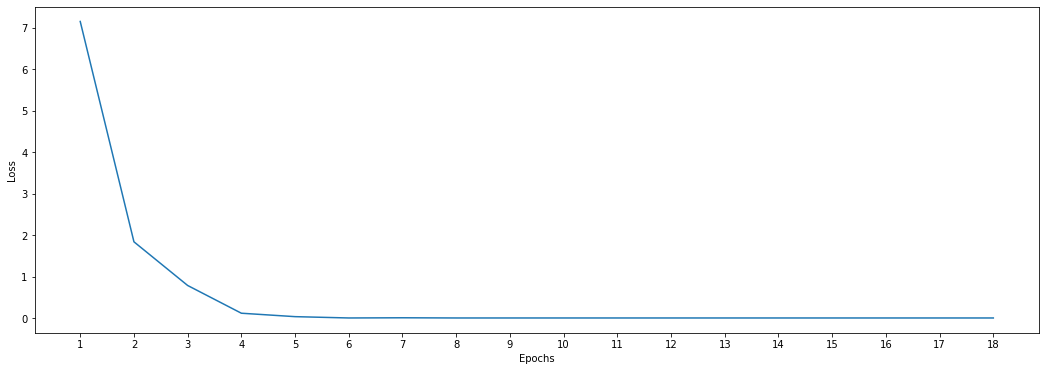

In [24]:
plt.figure(figsize=(18,6))
xticks = np.arange(classifier.n_iter_) + 1
plt.plot(xticks, classifier.loss_curve_);
# plt.yscale('log');
plt.xticks(xticks);
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [25]:
classifier.score(X_test, Y_test)

0.8852459016393442

# Test model performances

In [26]:
Y_pred = classifier.predict(X_test)

In [27]:
class_labels = CLASSES + ['Other'] if WITH_OTHER else CLASSES
print(classification_report(Y_test, Y_pred, target_names=class_labels))

              precision    recall  f1-score   support

          Ia       0.96      1.00      0.98        22
         IIb       1.00      0.50      0.67         4
        IIIb       0.67      0.75      0.71         8
       Other       0.89      0.89      0.89        27

    accuracy                           0.89        61
   macro avg       0.88      0.78      0.81        61
weighted avg       0.89      0.89      0.88        61



In [28]:
test_df = pd.DataFrame(shuffled_df[train_size:])

In [29]:
test_df['y_pred'] = list(map(inverse_class_mapper, Y_pred))
test_df['y_true'] = list(map(inverse_class_mapper, Y_test))

In [30]:
test_df['correct'] = (Y_pred == Y_test).astype('int32')

In [31]:
test_df

,filename,stone_class,class_level_1,class_level_2,filetype,SUR,SEC,type_image,class_number,y_pred,y_true,correct
3,Ia_SUR_25.jpg,Ia,I,a,jpg,True,False,SUR,0,Ia,Ia,1
95,IIIb_SEC_15.jpg,IIIb,III,b,jpg,False,True,SEC,2,IIIb,IIIb,1
37,Ia_SEC_25.jpg,Ia,I,a,jpg,False,True,SEC,0,Ia,Ia,1
186,Va_SEC_1.png,Va,V,a,png,False,True,SEC,3,Other,Other,1
27,Ia_SUR_9.jpg,Ia,I,a,jpg,True,False,SUR,0,Ia,Ia,1
...,...,...,...,...,...,...,...,...,...,...,...,...
140,Va_SUR_5.png,Va,V,a,png,True,False,SUR,3,Other,Other,1
151,Ia_SUR_2.jpg,Ia,I,a,jpg,True,False,SUR,0,IIb,Ia,0
133,IIb_SUR_20.jpg,IIb,II,b,jpg,True,False,SUR,1,IIb,IIb,1
113,Va_SUR_4.png,Va,V,a,png,True,False,SUR,3,Other,Other,1


In [36]:
test_df.groupby('type_image').plot.bar(['y_pred', 'y_true'], legend=True, figsize=(18,6));

ValueError: x must be a label or position

In [ ]:
def create_classifier(input_shape, layers, nb_classes):
    X = tf.keras.Input(shape=input_shape)
    
    processing = X
    for layer in layers:
        if type(layer) is int:
            processing = tf.keras.layers.Dense(layer, activation='relu')